# Parallelization, Subgraphs
- Fan-in and Fan-out

In [26]:
from typing import Annotated, TypedDict, Any
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, RemoveMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.errors import InvalidUpdateError

from IPython.display import display, Image

In [2]:
load_dotenv()

True

In [17]:
class State(TypedDict):
    messages: list[str]

In [18]:
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['messages']}")
        return {"messages": [self._value]}

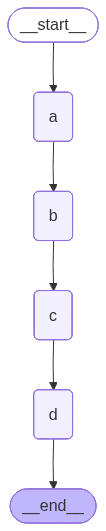

In [19]:
# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
graph.invoke({"messages": []}) ## Starting with empty list

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'messages': ["I'm D"]}

#### fan-out from `a` to `b and c`, and then fan-in to `d`.

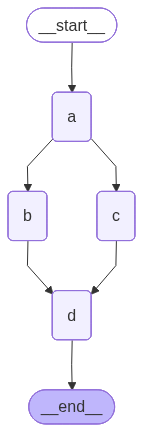

In [23]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
try:
    graph.invoke({"messages": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occurred: At key 'messages': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


#### Lets solve this issue via some concatenator
- `operator`
- `add_messages` - Need to check this

In [29]:
import operator

In [30]:
class State(TypedDict):
    messages: Annotated[list, operator.add]

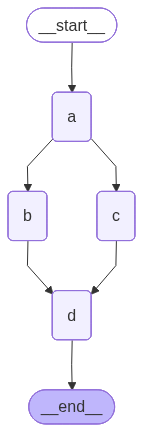

In [31]:
# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'messages': ["I'm A", "I'm B", "I'm C", "I'm D"]}

#### Now, lets consider a case where one parallel path has more steps than the other one.

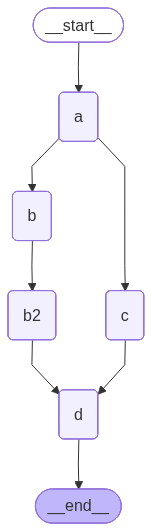

In [33]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'messages': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

#### Use add_messages